In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn.functional as F
from tqdm.auto import tqdm,trange
from pathlib import Path
import pandas as pd
import torch.nn.utils.prune as prune
import numpy as np
import random
import learn2learn as l2l
import pickle
import matplotlib.pyplot as plt

/home/samuel/.conda/envs/meta/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
ways = 5 
shots =5

In [4]:
with open("./data/test.pkl",'rb') as f:
    test_data = pickle.load(f)
with open("./data/train.pkl",'rb') as f:
    train_data = pickle.load(f)
with open("./data/validation.pkl",'rb') as f:
    val_data = pickle.load(f)

In [5]:
train_data['images'].shape

(38400, 3, 84, 84)

In [6]:
class Dataset(Dataset):
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir
        self.data = self.load_data(self.data_dir)
        self.transform = transform
        self.images = np.transpose(self.data['images'],(0,2,3,1))
        self.labels = self.data['labels']
        # self.labels = self.data['labels']
        # self.images = self.data['images']
    def load_data(self,data_dir):
        with open(data_dir,'rb') as f:
            data = pickle.load(f)
        return data
    def __len__(self): 
        return len(self.data['images'])
    def __getitem__(self,index):
        img = self.images[index]
        label = self.labels[index]
        # print(img.shape)
        if self.transform:
            img = self.transform(img)
        return img, label

In [7]:
train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=3),
        transforms.Normalize((0.5,), (0.5,))
    ])
val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=3),
        transforms.Normalize((0.5,), (0.5,))
])

In [8]:
train_dataset = Dataset("./data/train.pkl",train_transform)
val_dataset = Dataset("./data/validation.pkl", val_transform)

In [9]:
train_dataset = l2l.data.MetaDataset(train_dataset)
val_dataset = l2l.data.MetaDataset(val_dataset)

In [10]:
task_transforms = [
    l2l.data.transforms.FusedNWaysKShots(train_dataset, n=ways, k=2*shots),
    l2l.data.transforms.LoadData(train_dataset),
    l2l.data.transforms.RemapLabels(train_dataset),
    l2l.data.transforms.ConsecutiveLabels(train_dataset),
]
train_taskset =  l2l.data.TaskDataset(train_dataset, task_transforms, num_tasks=20000)
task_transforms = [
    l2l.data.transforms.FusedNWaysKShots(val_dataset, n = ways, k=2*shots),
    l2l.data.transforms.LoadData(val_dataset),
    l2l.data.transforms.RemapLabels(val_dataset),
    l2l.data.transforms.ConsecutiveLabels(val_dataset),
]
val_taskset =  l2l.data.TaskDataset(val_dataset, task_transforms, num_tasks=20000)

In [11]:
# task visualize
# for i in range(5):
#     img = train_taskset[3][0][i]
#     transform = torchvision.transforms.ToPILImage()
#     img = transform(img[0])
#     img.show()

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3,64,3,padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(64,64,3,padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,128,3,padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128,128,3,padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.fc = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,ways),
        )
    def forward(self,x):
        x = self.cnn(x)
        x = x.view(x.shape[0],-1)
        return self.fc(x)

In [13]:
maml_lr = 0.5
lr = 1e-3
EPOCHS = 10000
meta_batch = 32
fas = 1

In [14]:
model = Model().to(device)
meta_model = l2l.algorithms.MAML(model, lr=maml_lr,first_order=False)
opt = torch.optim.Adam(meta_model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss(reduction='mean')

In [12]:
def adaptation(task, learner, fas,loss_func, device):
    data, labels = task
    data = data.to(device)
    labels = labels.to(device)
    sup_mask = np.array(([False]*5+[True]*5)*5)
    query_mask = ~sup_mask
    sup_data , query_data = data[sup_mask], data[query_mask]
    sup_labels , query_labels = labels[sup_mask], labels[query_mask]
    for step in range(fas): # inner loop
        pred = learner(sup_data)
        train_loss = loss_func(pred, sup_labels)
        learner.adapt(train_loss)
    query_pred = learner(query_data)
    query_loss = loss_func(query_pred,query_labels)
    query_acc = (torch.argmax(query_pred,1)==query_labels).sum()/len(query_labels)
    return query_loss, query_acc

def train(EPOCHS, meta_model, train_taskset, val_taskset, loss_func, opt, device, output_file):
    log_file = f"{output_file}.txt"
    res = {
        "train_acc_list" : [],
        "val_acc_list" : [],
    }
    for epoch in trange(EPOCHS):
        opt.zero_grad()
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        for _ in range(meta_batch):
            learner = meta_model.clone(first_order = False)
            task = train_taskset.sample() # sample 一組 [50,3,84,84],[50]
            query_loss, query_acc = adaptation(task, learner,fas, loss_func, device)
            query_loss.backward()
            train_loss+=query_loss.item()
            train_acc+=query_acc.item()
            #validation
            learner = meta_model.clone(first_order = False)
            task = val_taskset.sample() # sample 一組 [50,3,84,84],[50]
            query_loss, query_acc = adaptation(task, learner,fas, loss_func, device)
            val_loss+=query_loss.item()
            val_acc +=query_acc.item()
        res["train_acc_list"].append((train_acc/meta_batch))
        res["val_acc_list"].append((val_acc/meta_batch))
        out = {
            "Epoch" : epoch,
            "train accuracy" : (train_acc/meta_batch),
            "validation accuracy" : (val_acc/meta_batch),
            "train loss" : (train_loss/meta_batch),
            "validation loss" : (val_loss/meta_batch)
        }
        with open(log_file,"a") as f:
            f.write(str(out) + '\n')
        if (epoch+1)%50==0:
            print(f"Epoch {epoch+1} | Train loss :{train_loss/meta_batch} | Train accuracy : {train_acc/meta_batch}")
            print(f"Epoch {epoch+1} | Validation loss :{val_loss/meta_batch} | Validation accuracy : {val_acc/meta_batch}")
        for p in meta_model.parameters():
            p.grad.data.mul_(1.0 / meta_batch)
        opt.step()
    return res

In [13]:
def test(meta_model, test_data, loss_func, device):
    test_loss = 0
    test_acc = 0
    test_sup_images = test_data['sup_images']
    test_sup_labels = test_data['sup_labels']
    test_qry_images = test_data['qry_images']
    all_pred = []
    for i in trange(len(test_sup_images)):
        learner = meta_model.clone(first_order = False)
        sup_image = torch.tensor(test_sup_images[i]).to(device)
        sup_label = torch.tensor(test_sup_labels[i]).to(device)
        qry_image = torch.tensor(test_qry_images[i]).to(device)
        for step in range(fas): # inner loop
            pred = learner(sup_image)
            train_loss = loss_func(pred, sup_label)
            learner.adapt(train_loss)
        output_pred = torch.argmax(learner(qry_image),1).reshape(-1,1).detach().cpu().numpy()
        all_pred += [item for sublist in output_pred for item in sublist]
    return all_pred

In [ ]:
results  = train(EPOCHS, meta_model, train_taskset, val_taskset, loss_func,opt, device, "test")

<Axes: >

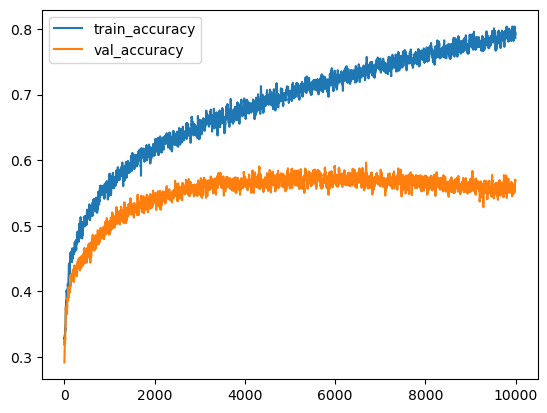

In [47]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
df1 = pd.DataFrame(moving_average(results["train_acc_list"],10),columns=['train_accuracy'])
df2 = pd.DataFrame(moving_average([i.item() for i in results["val_acc_list"]],10),columns=['val_accuracy'])
df = pd.concat([df1,df2],axis=1)
df.plot()

In [59]:
pred_res = test(meta_model, test_data, loss_func, device)

In [42]:
df = pd.concat([pd.Series(range(15000)),pd.Series(pred_res)],axis = 1)
df = df.rename(columns={df.columns[0]:"Id",df.columns[1]:"Category"})
df.to_csv("submission.csv", index =False)

# Grid search

In [ ]:
res_list = {}
for maml_lr in [0.5,0.3,0.1]:
    for lr in [1e-3, 3*1e-3, 1e-4]:
        meta_batch = 32
        fas = 1
        model = Model().to(device)
        meta_model = l2l.algorithms.MAML(model, lr=maml_lr,first_order=False)
        opt = torch.optim.Adam(meta_model.parameters(), lr=lr)
        loss_func = nn.CrossEntropyLoss(reduction='mean')
        res = train(5000, meta_model, train_taskset, val_taskset, loss_func, opt, device, f"maml_{maml_lr}|lr_{lr}")
        res_list[f"maml_{maml_lr}|lr_{lr}"] = res
        torch.save(meta_model.state_dict(),f"./model/model_maml_{maml_lr}|lr_{lr}.pt")

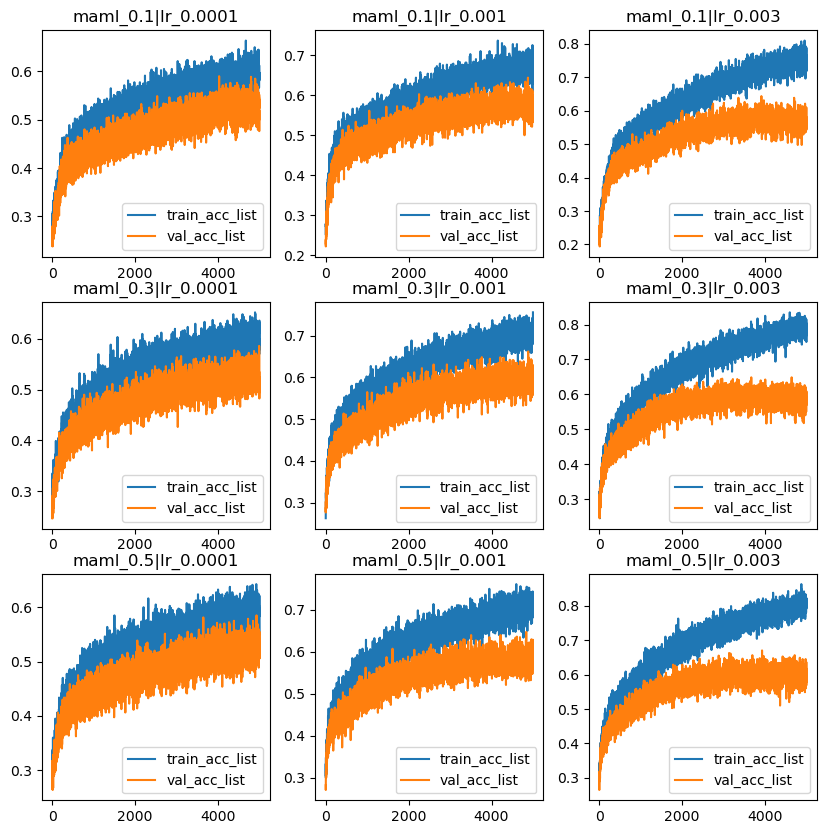

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
fig,ax = plt.subplots(3,3,figsize=(10,10))
k=0
for i,maml_lr in enumerate([0.1,0.3,0.5]):
    for k,lr in enumerate([1e-4,1e-3,3*1e-3]):
        data = res_list[f"maml_{maml_lr}|lr_{lr}"]
        df = pd.DataFrame(data)
        plt.figure()
        df.plot(ax = ax[i][k], title = f"maml_{maml_lr}|lr_{lr}")
        
        